In [1]:
%matplotlib inline
import numpy as np
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# 500 max word length, LSTM only architecture, 20 of the top level classes, 100 epochs
# predictionPath = 'results/epochPreds_500ML_LSTM_20Class.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class.png'

# predictionPath = 'results/epochPreds_500ML_LSTM_20Class_paddingFix.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class_paddingFix.npy'
# avgLossValidPath = 'results/epochAvgLossValid_500ML_LSTM_20Class_paddingFix.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class_paddingFix.png'
# precRecSavePath = 'src/plotting/resultPlotting/precRec_500ML_LSTM_20Class_paddingFix.png'
# rankMetricsPath = 'src/plotting/resultPlotting/rankMetricsPerf_500ML_LSTM_20Class_paddingFix.png'
# coverageErrorPath = 'src/plotting/resultPlotting/coverageError_500ML_LSTM_20Class_paddingFix.png'

# truePath = 'results/yDev.npy'

# resultPath = 'results/LSTM_300embed_500ML_50Hidden_baseline/'
# resultPath = 'results/LSTM_300embed_500ML_100Hidden/'
resultPath = 'results/rerunWithLongerNotes/'

In [3]:
epochAvgLoss = np.loadtxt(os.path.join(resultPath, 'epochAvgLoss.gz'))
epochAvgLossValid = np.loadtxt(os.path.join(resultPath, 'epochAvgLossValid.gz'))
yDev = np.loadtxt(os.path.join(resultPath, 'yDev.gz'))
epochPredictions = np.loadtxt(os.path.join(resultPath, 'epochPreds.gz'))
predsRealShape = np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)
# epochPredictions = epochPredictions.reshape((epochAvgLoss.shape[0], yDev.shape[0], yDev.shape[1]))
epochPredictions = epochPredictions.reshape(predsRealShape)

In [4]:
np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)

array([   14, 13181,    19])

In [5]:
print(epochPredictions.shape)
print(epochAvgLoss.shape)
print(yDev.shape)

(14, 13181, 19)
(14,)
(13181, 19)


In [6]:
with open(os.path.join(resultPath, 'hyperParamDict.pickle'), 'rb') as handle:
    hyperParamDict = pickle.load(handle)
pp.pprint(hyperParamDict)

{   'EMBED_SIZE': 300,
    'batchSize': 256,
    'inputKeepProb': 1,
    'learningRate': 0.001,
    'maxGradNorm': 5,
    'maxNoteLength': 1500,
    'n_hidden': 200,
    'numLayers': 1,
    'outputKeepProb': 0.5,
    'trainingEpochsMax': 100}


In [7]:
predsRaw = scipy.special.expit(epochPredictions)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
bestEpoch = np.argmin(epochAvgLossValid)
nEpochs = epochPredictions.shape[0]

In [8]:
epochAvgLossValid

array([ 0.48369277,  0.474305  ,  0.45792258,  0.44521585,  0.43692476,
        0.42672026,  0.41310978,  0.40611473,  0.39921346,  0.39648607,
        0.39355129,  0.39400458,  0.39808896,  0.40301883])

In [9]:
bestEpoch = np.argmin(epochAvgLossValid)
# kinda hacky but I assume it would never be exactly zero.
print('best model at epoch %d with a validation loss of %.5f'%(bestEpoch, epochAvgLossValid[bestEpoch]))

best model at epoch 10 with a validation loss of 0.39355


In [10]:
precOverEpoch = np.zeros(preds.shape[0])
recOverEpoch = np.zeros(preds.shape[0])
f1OverEpoch = np.zeros(preds.shape[0])
coverErrOverEpoch = np.zeros(preds.shape[0])
rankLossOverEpoch = np.zeros(preds.shape[0])
lrapOverEpoch = np.zeros(preds.shape[0])
for epoch in range(preds.shape[0]):
    prec = metrics.precision_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    rec = metrics.recall_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    f1 = metrics.f1_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    coverErr = metrics.coverage_error(yDev, predsRaw[epoch, :,:])
    rankLoss = metrics.label_ranking_loss(yDev, predsRaw[epoch,:,:])
    lrap = metrics.label_ranking_average_precision_score(yDev, predsRaw[epoch,:,:])
    coverErrOverEpoch[epoch] = coverErr
    rankLossOverEpoch[epoch] = rankLoss
    lrapOverEpoch[epoch] = lrap
    precOverEpoch[epoch] = prec
    recOverEpoch[epoch] = rec
    f1OverEpoch[epoch] = f1

/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [11]:
prec = metrics.precision_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))
print('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])
with open(os.path.join(resultPath, 'bestPerformance.txt'), 'w') as performanceFile:
    performanceFile.write('Precsion score averaged over samples %f \n'%(prec))
    performanceFile.write('Recall score averaged over samples %f \n'%(rec))
    performanceFile.write('F1 score averaged over samples %f \n'%(f1))
    performanceFile.write('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])

Precsion score averaged over samples 0.796059
Recall score averaged over samples 0.666398
F1 score averaged over samples 0.698700
Rank loss 0.407888 



/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


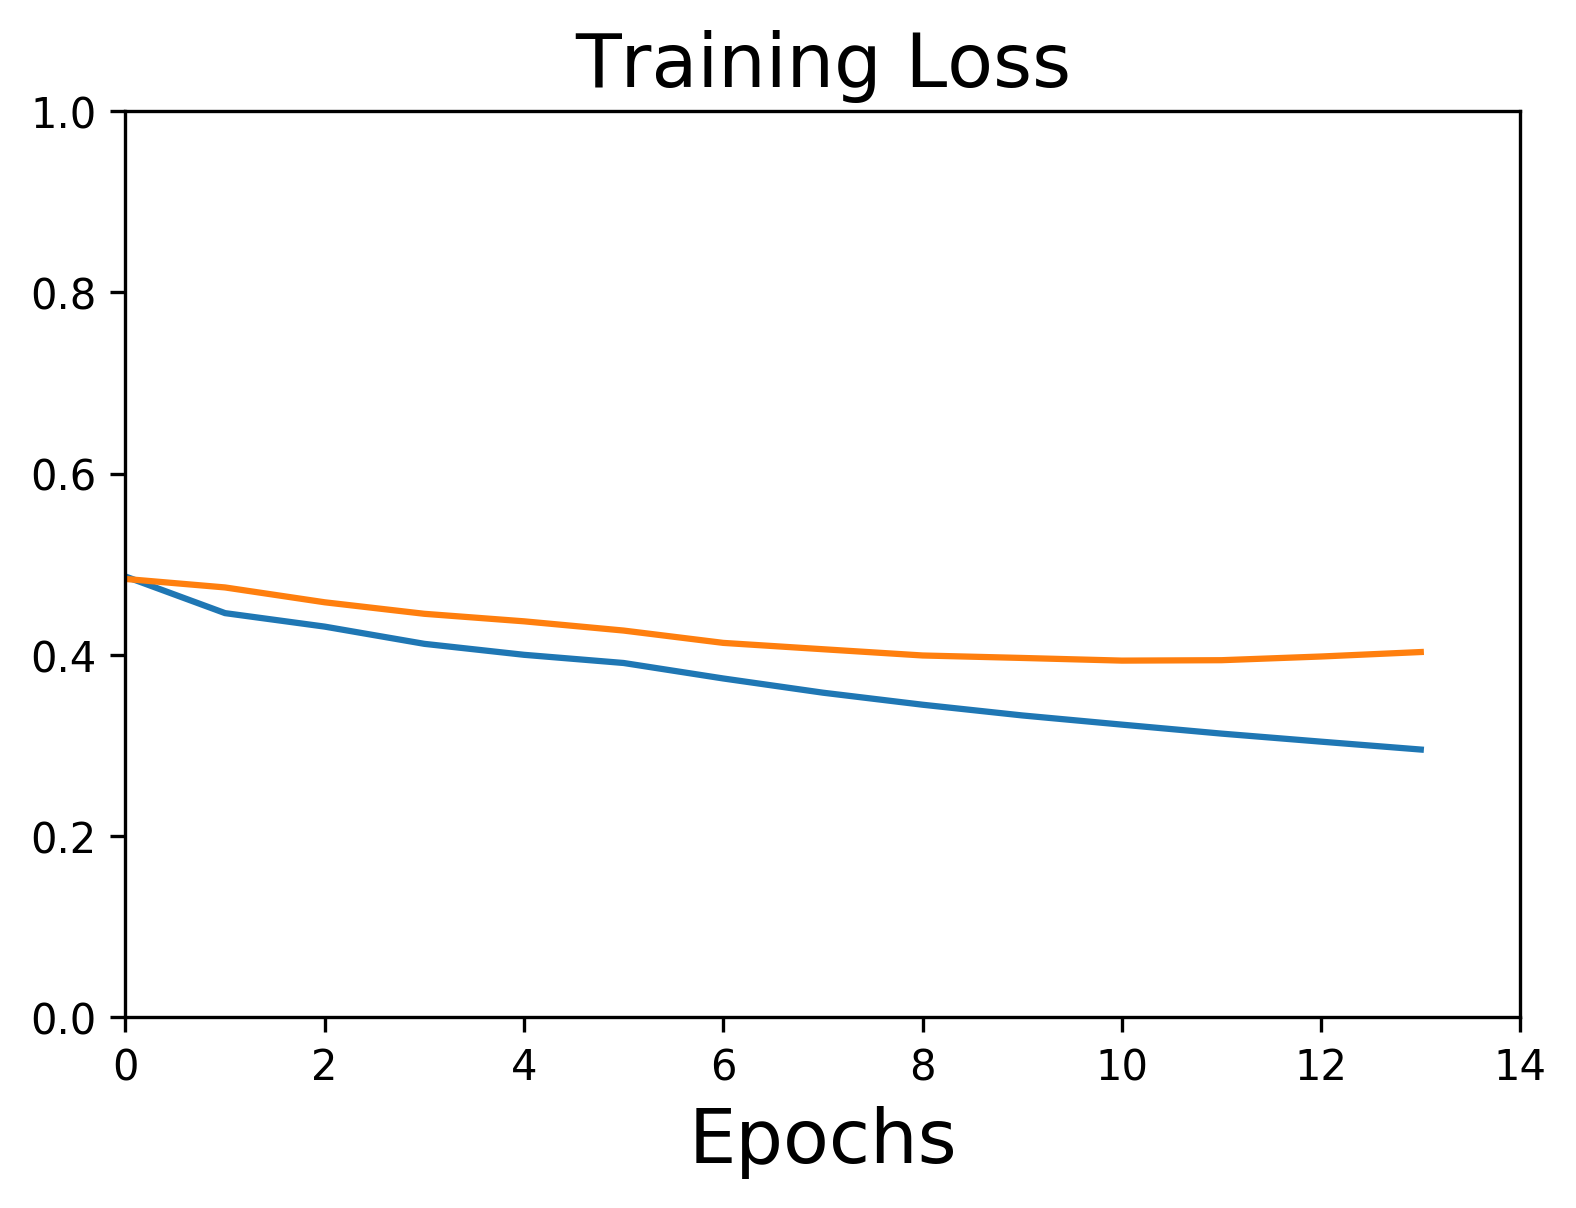

In [12]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, epochAvgLoss)
plt.plot(x, epochAvgLossValid)
plt.axis([0, epochPredictions.shape[0], 0, 1.0])
plt.title('Training Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'loss.png'))

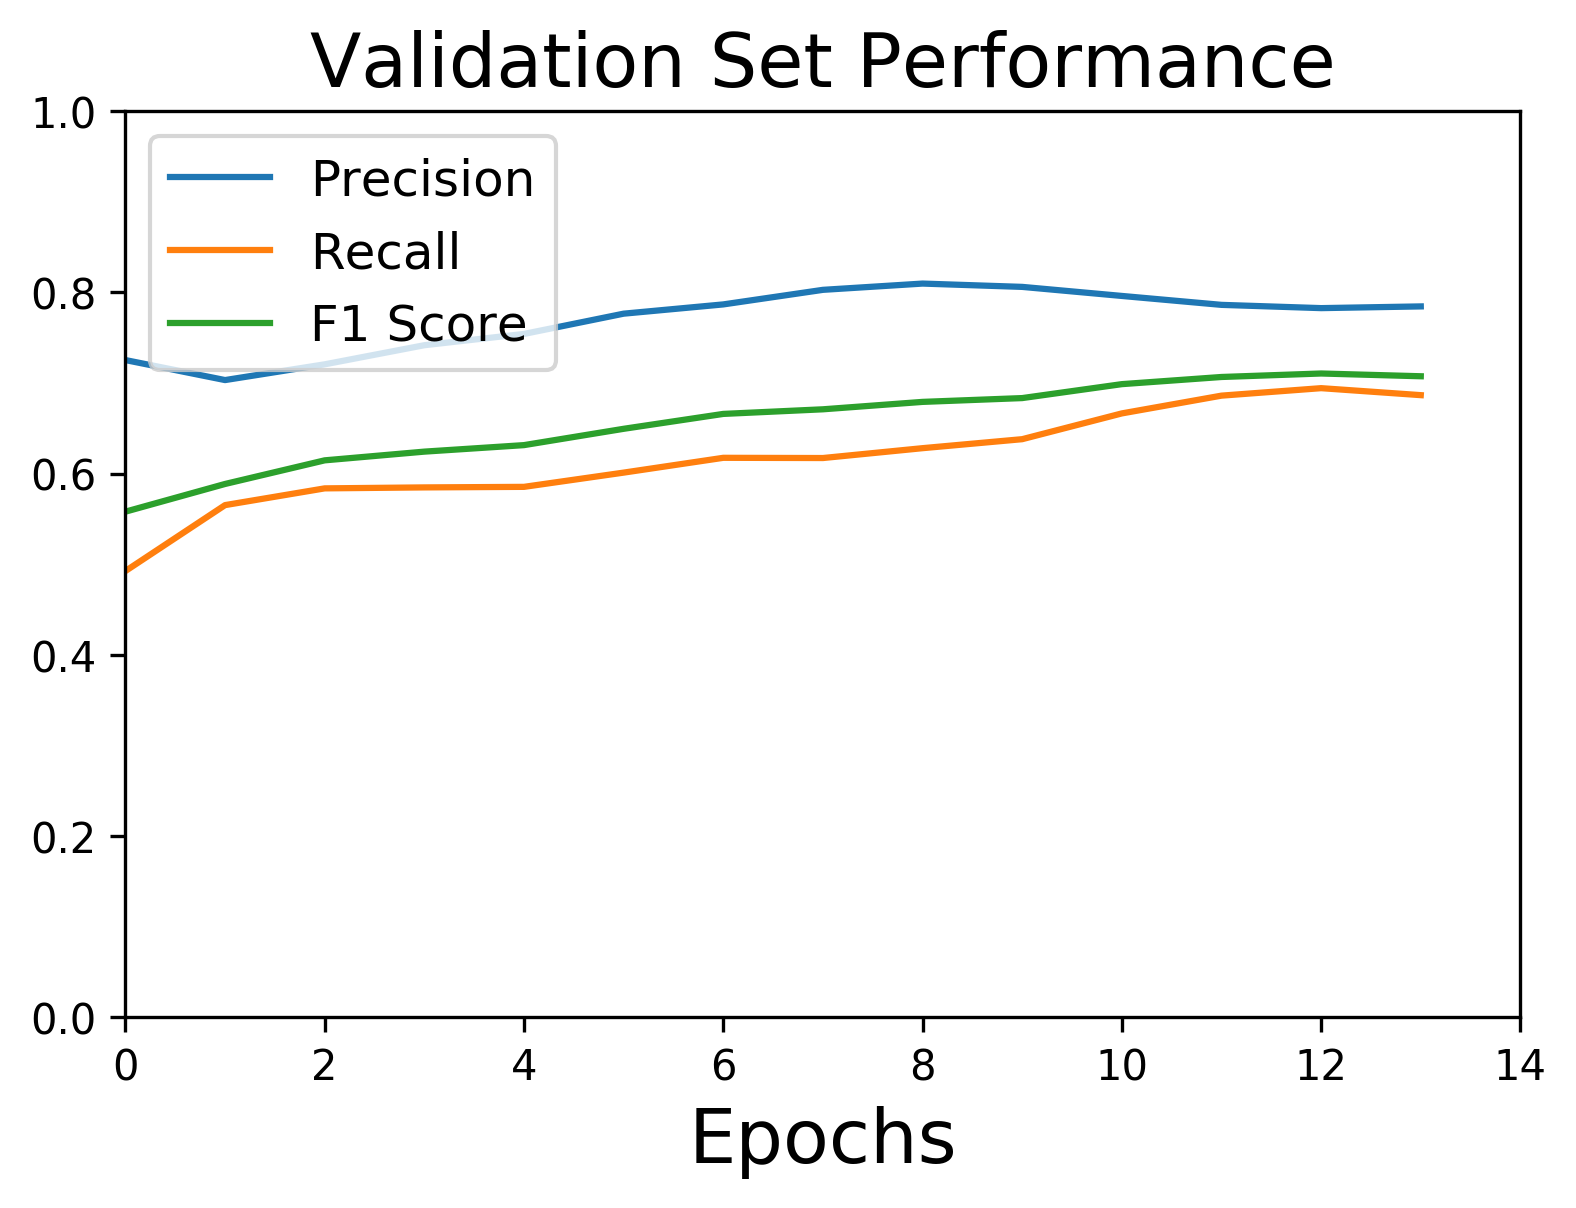

In [13]:
nEpochs = preds.shape[0]
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, precOverEpoch)
plt.plot(x, recOverEpoch)
plt.plot(x, f1OverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize = 12)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'precRecF1.png'))
# fig.savefig('src/plotting/resultPlotting/performance.png')

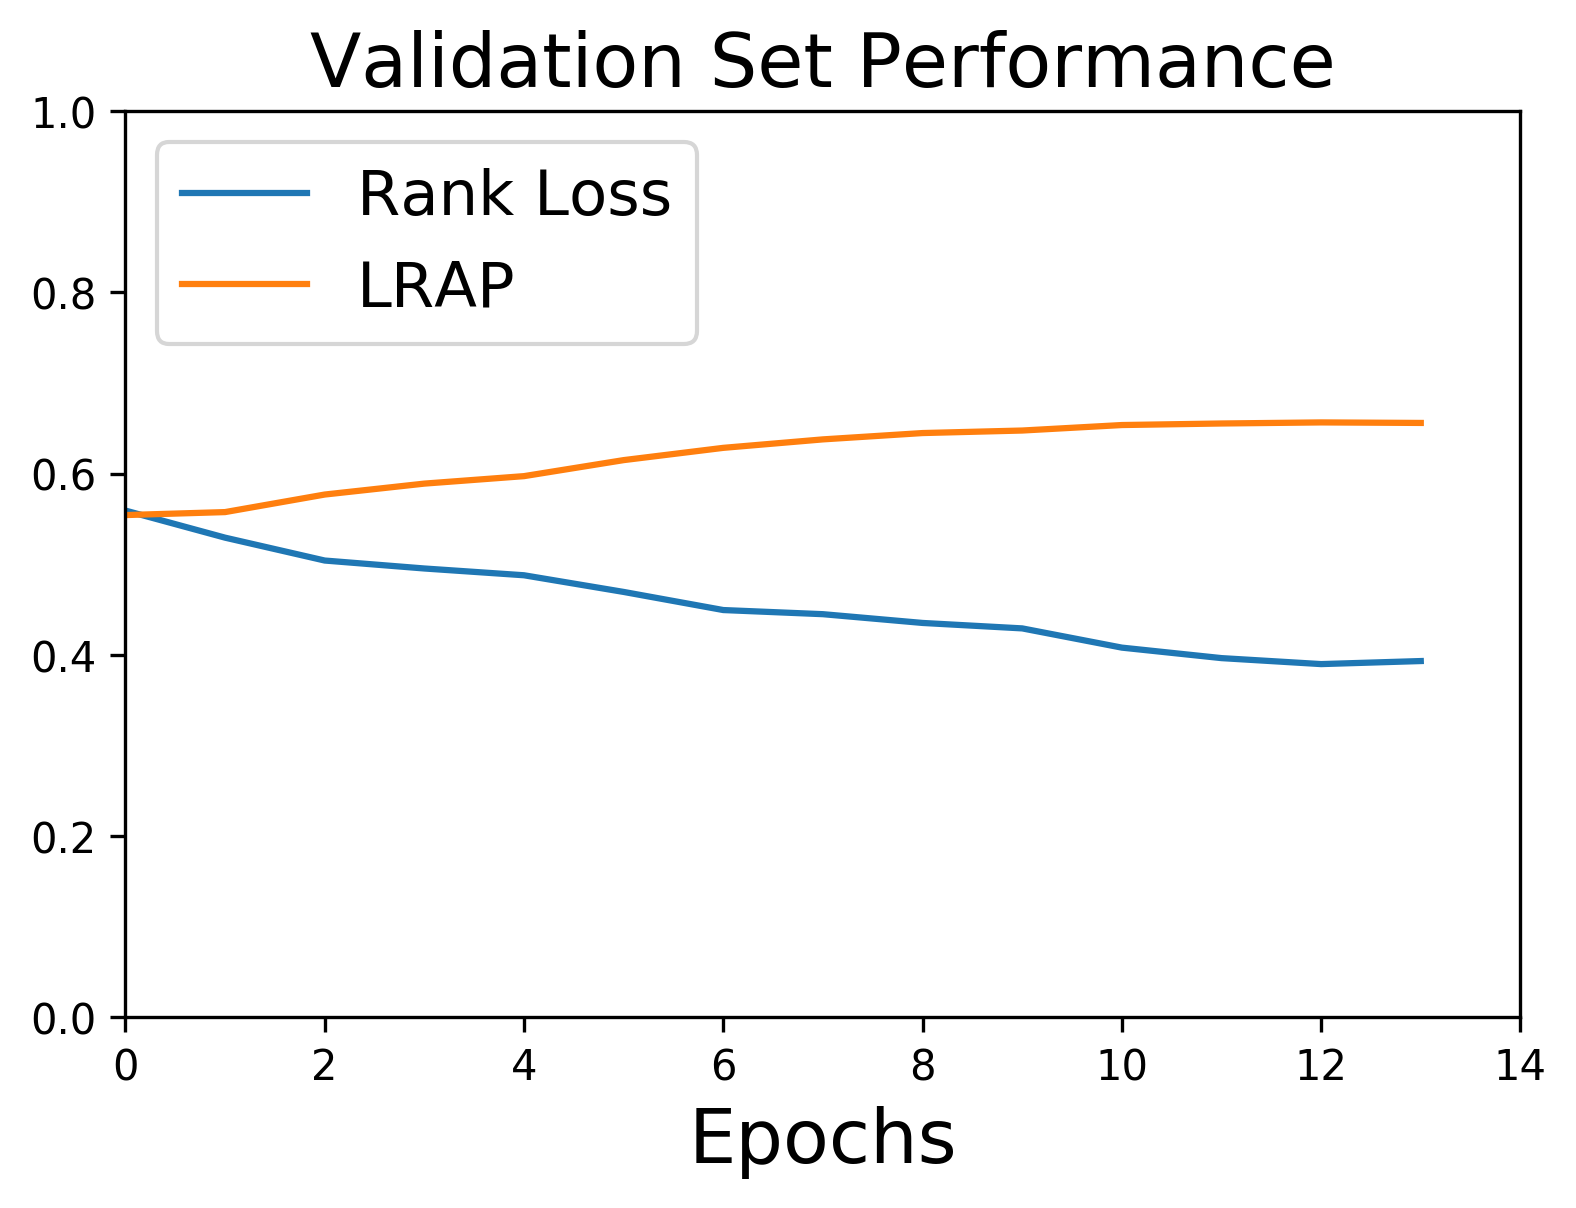

In [14]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, rankLossOverEpoch)
plt.plot(x, lrapOverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Rank Loss', 'LRAP'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'rankLoss.png'))

The mean number of codes in the devSet is 6.698


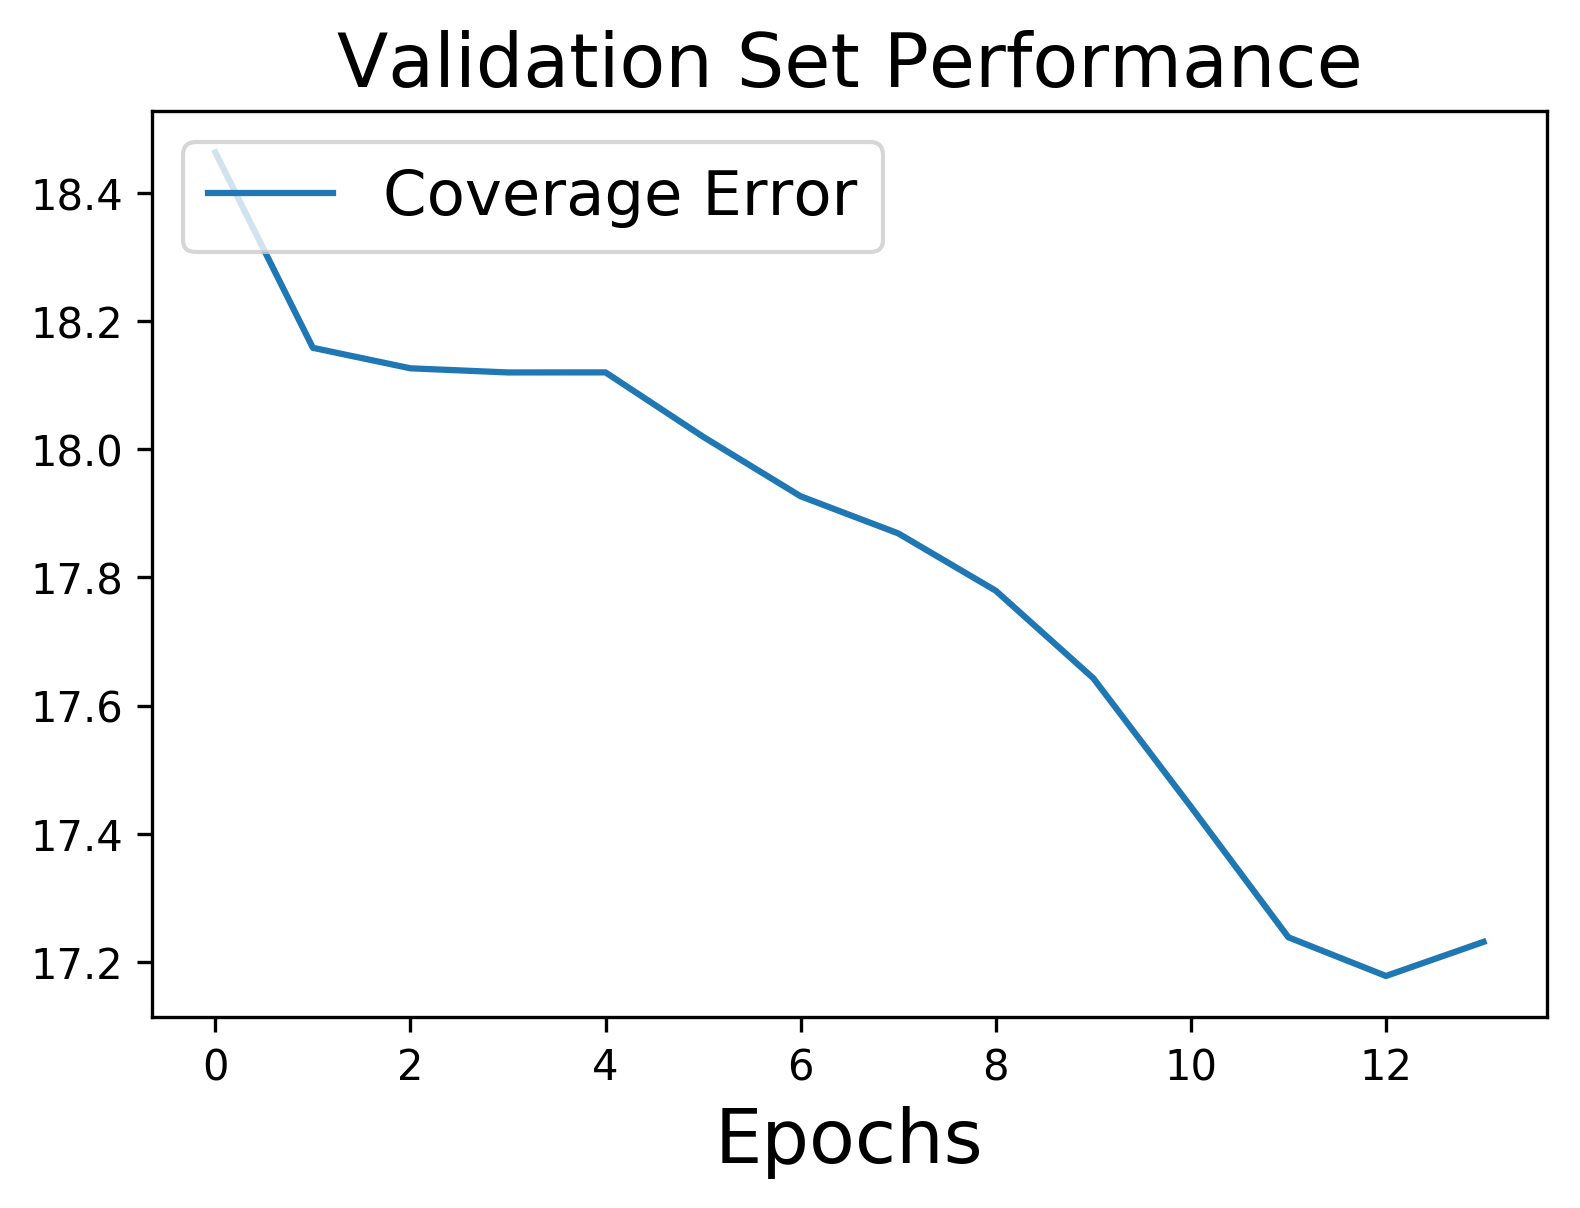

In [15]:
meanNumberOfCodes = np.sum(yDev, axis = 1)
meanNumberOfCodes = np.mean(meanNumberOfCodes)
print('The mean number of codes in the devSet is %.3f'%meanNumberOfCodes)
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, coverErrOverEpoch)

plt.legend(['Coverage Error'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'coverage.png'))

## Confusion Matrices
Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.


As of right now this code isn't real

In [16]:
with open(os.path.join(resultPath, 'features.pkl'), 'rb') as handle:
    icdDict = pickle.load(handle)[2]
#     icdDict = temp[2]
pp.pprint(icdDict)

{   'cat:1': 14,
    'cat:10': 10,
    'cat:11': 8,
    'cat:12': 5,
    'cat:13': 13,
    'cat:14': 1,
    'cat:15': 6,
    'cat:16': 18,
    'cat:17': 7,
    'cat:18': 2,
    'cat:19': 11,
    'cat:2': 17,
    'cat:3': 9,
    'cat:4': 3,
    'cat:5': 12,
    'cat:6': 0,
    'cat:7': 16,
    'cat:8': 15,
    'cat:9': 4}


In [20]:
predsBest = preds[bestEpoch,:,:]
yTruth = yDev
# confusionMatrix = np.zeros(shape = (temp.shape[1], temp.shape[1]))
# print(confusionMatrix)-
# currTruth = np.zeros(temp.shape[1])
# currPred = np.zeros(temp.shape[1])
for colIdx in range(yTruth.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = predsBest[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
    print(confMat)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    print('total positives {} or {} of the total'.format(np.sum(currPred), np.mean(currPred)))
    print('precision {}'.format(prec))
    print('recall {}'.format(rec))
    print('f1 score {}'.format(f1))
    print('***************************')
#     1/0

[[8130  834]
 [2228 1989]]
total positives 2823.0 or 0.21417191411880737 of the total
precision 0.7045696068012752
recall 0.4716623191842542
f1 score 0.5650568181818182
***************************
[[10029    83]
 [ 2990    79]]
total positives 162.0 or 0.012290418025946439 of the total
precision 0.4876543209876543
recall 0.025741283805799934
f1 score 0.048901268956979264
***************************
[[6245 1192]
 [2623 3121]]
total positives 4313.0 or 0.3272134132463394 of the total
precision 0.7236262462323209
recall 0.5433495821727019
f1 score 0.6206622253157005
***************************
[[6252 1404]
 [2968 2557]]
total positives 3961.0 or 0.3005083074121842 of the total
precision 0.645544054531684
recall 0.4628054298642534
f1 score 0.5391102677630192
***************************
[[5285  986]
 [1522 5388]]
total positives 6374.0 or 0.4835748425764358 of the total
precision 0.845309068089112
recall 0.779739507959479
f1 score 0.8112014453477867
***************************
[[13158     0

/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


recall 0.9187843057532019
f1 score 0.8588531521687491
***************************
[[5986 1411]
 [1279 4505]]
total positives 5916.0 or 0.4488278582808588 of the total
precision 0.7614942528735632
recall 0.7788727524204703
f1 score 0.77008547008547
***************************
[[1942 1885]
 [1750 7604]]
total positives 9489.0 or 0.7198998558531219 of the total
precision 0.8013489303403941
recall 0.8129142612785973
f1 score 0.8070901661094304
***************************
[[7190 1249]
 [1889 2853]]
total positives 4102.0 or 0.3112055231014339 of the total
precision 0.6955143832276938
recall 0.6016448755799241
f1 score 0.6451831750339213
***************************
[[11439    59]
 [ 1619    64]]
total positives 123.0 or 0.00933161368636674 of the total
precision 0.5203252032520326
recall 0.038027332144979206
f1 score 0.07087486157253599
***************************
[[8263  780]
 [1748 2390]]
total positives 3170.0 or 0.2404976860632729 of the total
precision 0.7539432176656151
recall 0.577573

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


for i in range(preds.shape[0]):
    cm = confusion_matrix(y_target=yTruth[:,i], 
                          y_predicted=preds[99,:,i])
    plot_confusion_matrix(conf_mat=cm)
    plt.show()
